# Linear regression model: the solution

You have now tried to build a linear regression model on the social media data set to find out whether the number of groups a person belongs to can explain the number of friends they have on Facebook. Let's recap:

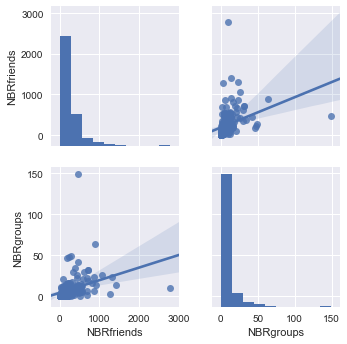

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Read in the data 
social_media = pd.read_csv("social_media.csv")

#Make a pair plot from the seaborn package
import seaborn as sea 
sea.pairplot(social_media, kind = "reg")
plt.show()


Linear regression seems plausible, but the data is very skewed and there are some outliers that might have cluttered our model. You can choose to make a model without adressing these issues, but it would be more performant when transforming your data. 

Therefore, I decided to transform the data using the following procedures: 
(1) do a logarithmic transformation of both the dependent and independent variable, and if necessary 
(2) remove the remaining outliers. 

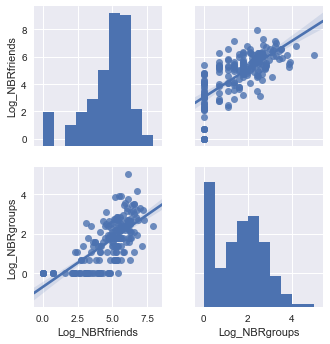

In [2]:
#Transform both varaibles to log
social_media_log = pd.DataFrame()

#We perform a log(x+1) tranformation since values of 0 would give inf
social_media_log[["Log_NBRfriends"]] = np.log(social_media[["NBRfriends"]]+1)
social_media_log[["Log_NBRgroups"]] = np.log(social_media[["NBRgroups"]]+1)

#Build the seaborn plot again
sea.pairplot(social_media_log, kind = "reg")
plt.show()

Both the histogram and the scatter plot look better know, as we clearly notice a straight line through the data points. The histogram also tends towards a normal distribution. However, there might be some outliers still ahead, so let's try to see this by building a boxplot. 

C:\Anaconda\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


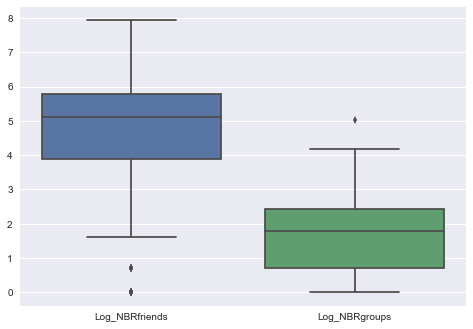

In [3]:
sea.boxplot(social_media_log)
plt.show()

There are two outliers for the number of friends and 1 outlier for the number of groups. Outliers are determined as observations outside the whiskers of the boxplot. In mathematical terms, these are observations outside the range of ]Q1 - 1.5IQR, Q3 + 1.5 IQR[, where IQR stands for the interquartile range (IQR = Q3-Q1) and Q1 is the first quartile (or the 25% percentile) and Q3 the third quartile (or the 75% percentile). The first (third) quartile is a number for which 25% (75%) of the data points lie below and 75% (25%) lie above this number. 

In [66]:
#Let's make a function to detect outliers 
#The function takes the data as input and returns the min (Q1 - 1.5IQR) value and max (Q3 + 1.5 IQR) value 
def get_outliers(data):
    
    min_q = max_q = 0
    
    ### BEGIN SOLUTION
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    min_q = q25 - (iqr*1.5)
    max_q = q75 + (iqr*1.5)
    ### END SOLTUON
    
    return min_q,max_q

C:\Anaconda\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


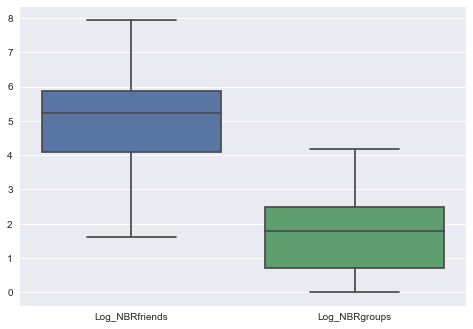

In [10]:
#To make sure that everyone has the solution and can continue with the exercise, I provide the outliers
outliers_friends= (1.0080437505546147, 8.6559952762896248)
outliers_groups = (-1.8966042241688035, 5.0093995217745269)

#All the values that fall out the above ranges are considered outliers, so we have to keep all the values within this range
social_media_cleaned = social_media_log[((social_media_log["Log_NBRfriends"] > outliers_friends[0]) &
                 (social_media_log["Log_NBRfriends"] < outliers_friends[1])) &
                ((social_media_log["Log_NBRgroups"] > outliers_groups[0]) &
                (social_media_log["Log_NBRgroups"] < outliers_groups[1]))]

#Make a boxplot to see whether there are outliers 
sea.boxplot(social_media_cleaned)   
plt.show()

### Modelling
Now that we have deleted the outliers, we can start modelling the simple linear regression model. I will always build two models: one without the logs and one with the logs, so that you can see the difference. I will only use the *statsmodels* package since this is more convenient to interpret the output. 


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

np.random.seed(40)

#Make a train and test split (70/30)
train, test = train_test_split(social_media, test_size=0.30)
train_log, test_log = train_test_split(social_media_log, test_size=0.30)

#Add the intercept
train = sm.add_constant(train)
test = sm.add_constant(test)

train_log = sm.add_constant(train_log)
test_log = sm.add_constant(test_log)

In [67]:
#Make function that calculates an OLS model with the statsmodels package
def fit_ols(data, xvars, yvars):
    
    ### BEGIN SOLUTION
    linreg = sm.OLS(data[yvars],data[xvars]).fit()
    ### END SOLUTION
    
    return linreg

Verify your results: 

In [61]:
linreg = fit_ols(data=train, xvars=["const","NBRgroups"], yvars="NBRfriends")
linreg_log = fit_ols(data=train_log, xvars=["const","Log_NBRgroups"], yvars= "Log_NBRfriends")

assert np.allclose(linreg.params,(168.812153,11.925267))
assert np.allclose(linreg_log.params, (3.011340,1.032526))

In [62]:
print(linreg.summary()), print(linreg_log.summary())

                            OLS Regression Results                            
Dep. Variable:             NBRfriends   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     19.37
Date:                Tue, 20 Aug 2019   Prob (F-statistic):           2.14e-05
Time:                        16:44:57   Log-Likelihood:                -1004.9
No. Observations:                 140   AIC:                             2014.
Df Residuals:                     138   BIC:                             2020.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        168.8122     34.609      4.878      0.0

(None, None)

When looking at the R-squared of both models, you clearly see that the logarithmic model explains more of the variance. This is mainly because there is a clearer linear relationship and the outliers are removed. For both models, we see that both the intercept, as well as the slope, are significant at a 5% significant level. 

For the first model, we see that if we were part of 0 groups, we would still have 161 friends (intercept). We also see that if we join an extra group we get 12 extra friends. However, this model has a low R-squared, so it is better to interpret the logarithmic model. This model says that if we weren't part of any group, we would have log(number of friends) of 3.0113. To get the actual value, we take the exp(3.0113) and this tells us that we would have 20 friends. Try to interpret the coefficient of the slope for practice.

### Prediction

Now that we have built a simple linear regrssion model, let's make a prediction on the test set using this model. Since I used the *statsmodels* package earlier, so I will use it again now. To practise, you could try the example using the *sklearn* package.  

In [63]:
#Make a function that predicts on the test set
def make_predictions(model, data):
    ### BEGIN SOLUTION
    pred = model.predict(data)
    ### END SOLUTION
    return pred

Verify your results:

In [64]:
#Make predictions
pred = make_predictions(model = linreg,data = test[["const","NBRgroups"]])

#Evaluate performance
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

print("MAE: "+str(mae(test[["NBRfriends"]],pred)))
print("RMSE: "+str(np.sqrt(mse(test[["NBRfriends"]],pred))))
print("R-squared: "+str(r2(test[["NBRfriends"]],pred)))

MAE: 164.292526665
RMSE: 257.870119438
R-squared: -0.232488374114


In [65]:
pred_log = make_predictions(linreg_log,test_log[["const","Log_NBRgroups"]])
assert np.allclose((mae(test_log[["Log_NBRfriends"]],pred_log),
                   np.sqrt(mse(test_log[["Log_NBRfriends"]],pred_log)), 
                   r2(test_log[["Log_NBRfriends"]],pred_log)),(0.916411951656,1.12493597611,0.477289969717))

If you would calculate the performance of the log model, you would see that the error rates are much lower. This is logical since the range of values is also a lot lower when taking the logarithm. However, the R-squared is a unitless measure and here we see a huge performance difference! The R-squared of the non-logarithmic model is even negative, indicating that the model is clearly misspecified.